# JMH Benchmark Parser & Plotting Toolkit

This notebook provides:
1. A parser to extract datasets from JMH-style table output into typed arrays grouped by benchmark name.
2. Plotting helpers to compare **2, 3, 4, or 5** datasets on one chart.
3. A regression plotter that overlays a polynomial fit of configurable degree.

**Conventions**
- Parsed structure per benchmark: `List[Tuple[int, Tuple[float, float]]]` → `(size, (avg, error))`.
- `size` is taken from the filename part like `... 2_456chars.json ...` → `456`.
- Plot functions accept optional `output_folder` and `fmt` (`"svg"` or `"eps"`). If provided, figures are saved there.


In [ ]:

# Imports (matplotlib only; seaborn intentionally not used)
from __future__ import annotations
import re
from typing import Dict, List, Tuple, Sequence, Iterable, Optional
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def _ensure_save(fig, filename: Optional[str|Path], fmt: str = "svg", output_folder: Optional[str|Path] = None):
    """Save `fig` if `output_folder` is provided. Returns output path or None."""
    if output_folder is None:
        return None
    fmt = (fmt or "svg").lower()
    if fmt not in {"svg", "eps"}:
        raise ValueError(f"Unsupported format: {fmt!r}. Use 'svg' or 'eps'.")
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)
    filename = Path(filename) if filename is not None else Path("figure")
    outpath = output_folder / (filename.stem + f".{fmt}")
    fig.savefig(outpath, format=fmt, bbox_inches="tight", dpi=300)
    return outpath


In [ ]:

def parse_jmh_table(raw_text: str) -> Dict[str, List[Tuple[int, Tuple[float, float]]]]:
    """Parse JMH-like '[info] Benchmark ...' table lines into datasets.

    Returns a dict mapping benchmark name → list of (size, (avg, error)).
    The list is sorted by size. Lines that don't match the expected table pattern are ignored.

    Expected columns pattern (loose, handles variable spacing):
      [info] <BenchmarkName> <file> <mode> <cnt> <score> ± <error> <units>

    Size extraction rule:
      Take the integer *immediately before* the 'chars' token in the filename.
      E.g., '102_23677chars.json' → 23677 ; '2_456chars.json' → 456.
    """
    datasets: Dict[str, List[Tuple[int, Tuple[float, float]]]] = {}

    # Regex for the table line
    line_re = re.compile(
        r"^\[info\]\s+"                               # prefix
        r"(?P<bench>\S+)\s+"                           # benchmark name
        r"(?P<file>\S+)\s+"                            # filename token
        r"(?P<mode>\S+)\s+"                            # mode (e.g., avgt)
        r"(?P<cnt>\d+)\s+"                             # count
        r"(?P<score>\d+(?:\.\d+)?)\s+"               # score (avg)
        r"±\s+"
        r"(?P<error>\d+(?:\.\d+)?)\s+"               # error
        r"(?P<units>\S+)\s*$"                          # units
    )

    # Extract the size found right before 'chars' inside the file token
    size_re = re.compile(r"_(?P<size>\d+)chars\b", re.IGNORECASE)

    for line in raw_text.splitlines():
        m = line_re.match(line)
        if not m:
            continue

        bench = m.group("bench")
        filetok = m.group("file")
        score = float(m.group("score"))
        error = float(m.group("error"))

        sm = size_re.search(filetok)
        if not sm:
            # If pattern fails, try to fallback to the last integer run in the token
            # (keeps the parser resilient for edge cases).
            m2 = re.search(r"(\d+)(?=\D*$)", filetok)
            if not m2:
                continue
            size = int(m2.group(1))
        else:
            size = int(sm.group("size"))

        datasets.setdefault(bench, []).append((size, (score, error)))

    # Sort each dataset by size
    for k in list(datasets.keys()):
        datasets[k].sort(key=lambda t: t[0])

    return datasets


In [ ]:

def _prep_xy(series: List[Tuple[int, Tuple[float, float]]]):
    xs = [s for s, _ in series]
    ys = [v[0] for _, v in series]
    yerr = [v[1] for _, v in series]
    return np.array(xs), np.array(ys), np.array(yerr)

def _plot_many(datasets: Sequence[Tuple[str, List[Tuple[int, Tuple[float, float]]]]], 
               title: Optional[str] = None,
               output_folder: Optional[str|Path] = None,
               fmt: str = "svg",
               filename: Optional[str|Path] = None):
    n = len(datasets)
    if n < 2 or n > 5:
        raise ValueError("_plot_many expects between 2 and 5 datasets.")

    fig, ax = plt.subplots(figsize=(7, 5))
    for label, series in datasets:
        xs, ys, yerr = _prep_xy(series)
        ax.errorbar(xs, ys, yerr=yerr, marker='o', linestyle='', label=label)
    ax.set_xlabel("Input size (chars)")
    ax.set_ylabel("Average time (us/op)")
    ax.grid(True, which='both', linestyle='--', alpha=0.4)
    if title:
        ax.set_title(title)
    ax.legend()

    saved = _ensure_save(fig, filename or (title or f"compare_{n}_datasets"), fmt, output_folder)
    plt.show()
    return saved

def plot2(d1: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
          d2: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
          title: Optional[str] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          filename: Optional[str|Path] = None):
    """Plot 2 datasets on the same axes."""
    return _plot_many([d1, d2], title, output_folder, fmt, filename)

def plot3(d1, d2, d3, title: Optional[str] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          filename: Optional[str|Path] = None):
    """Plot 3 datasets on the same axes."""
    return _plot_many([d1, d2, d3], title, output_folder, fmt, filename)

def plot4(d1, d2, d3, d4, title: Optional[str] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          filename: Optional[str|Path] = None):
    """Plot 4 datasets on the same axes."""
    return _plot_many([d1, d2, d3, d4], title, output_folder, fmt, filename)

def plot5(d1, d2, d3, d4, d5, title: Optional[str] = None,
          output_folder: Optional[str|Path] = None,
          fmt: str = "svg",
          filename: Optional[str|Path] = None):
    """Plot 5 datasets on the same axes."""
    return _plot_many([d1, d2, d3, d4, d5], title, output_folder, fmt, filename)


In [ ]:

def plot_with_regression(dataset: Tuple[str, List[Tuple[int, Tuple[float, float]]]],
                         degree: int = 1,
                         title: Optional[str] = None,
                         output_folder: Optional[str|Path] = None,
                         fmt: str = "svg",
                         filename: Optional[str|Path] = None):
    """Plot a dataset with error bars and overlay a polynomial regression of given degree.

    Parameters
    ----------
    dataset : (name, series) where series is List[(size, (avg, error))].
    degree : polynomial degree (>= 0).
    title : optional str for the plot title.
    output_folder : optional path to save the plot.
    fmt : 'svg' or 'eps' (default: 'svg').
    filename : optional filename stem for saving.
    """
    if degree < 0:
        raise ValueError("degree must be >= 0")

    label, series = dataset
    xs, ys, yerr = _prep_xy(series)

    # Fit polynomial
    coeffs = np.polyfit(xs, ys, deg=degree)
    poly = np.poly1d(coeffs)

    # Smooth line over the observed range
    xfit = np.linspace(xs.min(), xs.max(), 500)
    yfit = poly(xfit)

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.errorbar(xs, ys, yerr=yerr, marker='o', linestyle='--', label=f"{label} (data)")
    ax.plot(xfit, yfit, label=f"Poly deg {degree}")
    ax.set_xlabel("Input size (chars)")
    ax.set_ylabel("Average time (us/op)")
    ax.grid(True, which='both', linestyle='--', alpha=0.4)
    ax.legend()
    if title:
        ax.set_title(title)

    saved = _ensure_save(fig, filename or (title or f"regression_deg{degree}_{label}"), fmt, output_folder)
    plt.show()
    return saved



### Usage
```python
raw = """<paste your JMH output here>"""
data = parse_jmh_table(raw)

# Example: build tuples for plotting
bench1 = "JsonLexerBenchmark.lex_ZipperMem"
bench2 = "JsonLexerBenchmark.separability_pred"
d1 = (bench1, data[bench1])
d2 = (bench2, data[bench2])

# Compare two datasets
plot2(d1, d2, title="Lex vs Separability", output_folder="plots", fmt="svg")

# Regression for one dataset
plot_with_regression(d2, degree=1, title="Separability: Linear Fit", output_folder="plots", fmt="svg")
```


# Json Separability Predicate Benchmark Results

In [ ]:
raw = """
[info] Result "ch.epfl.lexer.benchmark.lexer.JsonLexerBenchmark.separability_pred":
[info]   6501.347 ±(99.9%) 121.222 us/op [Average]
[info]   (min, avg, max) = (6421.781, 6501.347, 6659.327), stdev = 80.181
[info]   CI (99.9%): [6380.124, 6622.569] (assumes normal distribution)
[info] # Run complete. Total time: 01:26:55
[info] REMEMBER: The numbers below are just data. To gain reusable insights, you need to follow up on
[info] why the numbers are the way they are. Use profilers (see -prof, -lprof), design factorial
[info] experiments, perform baseline and negative tests that provide experimental control, make sure
[info] the benchmarking environment is safe on JVM/OS/HW level, ask for reviews from the domain experts.
[info] Do not assume the numbers tell you what you want them to tell.
[info] Benchmark                               (file)  Mode  Cnt      Score      Error  Units
[info] JsonLexerBenchmark.lex_ZipperMem      102_23677chars.json  avgt   10  35981.325 ±  599.211  us/op
[info] JsonLexerBenchmark.lex_ZipperMem      122_28308chars.json  avgt   10  42694.918 ± 1154.272  us/op
[info] JsonLexerBenchmark.lex_ZipperMem      142_32958chars.json  avgt   10  48079.772 ± 1385.602  us/op
[info] JsonLexerBenchmark.lex_ZipperMem      162_37599chars.json  avgt   10  56432.218 ± 1483.416  us/op
[info] JsonLexerBenchmark.lex_ZipperMem      182_42231chars.json  avgt   10  62008.582 ±  994.884  us/op
[info] JsonLexerBenchmark.lex_ZipperMem        2_456chars.json  avgt   10    659.970 ±   20.938  us/op
[info] JsonLexerBenchmark.lex_ZipperMem      202_46879chars.json  avgt   10  70666.477 ± 2258.280  us/op
[info] JsonLexerBenchmark.lex_ZipperMem       22_5115chars.json  avgt   10   7839.284 ±  191.300  us/op
[info] JsonLexerBenchmark.lex_ZipperMem      222_51521chars.json  avgt   10  78711.751 ± 1178.192  us/op
[info] JsonLexerBenchmark.lex_ZipperMem      242_56154chars.json  avgt   10  78394.077 ± 1767.092  us/op
[info] JsonLexerBenchmark.lex_ZipperMem       42_9755chars.json  avgt   10  14327.826 ±  512.815  us/op
[info] JsonLexerBenchmark.lex_ZipperMem       62_14377chars.json  avgt   10  21324.393 ±  525.802  us/op
[info] JsonLexerBenchmark.lex_ZipperMem       82_19037chars.json  avgt   10  28541.615 ±  660.448  us/op
[info] JsonLexerBenchmark.separability_pred  102_23677chars.json  avgt   10   8024.700 ±   49.515  us/op
[info] JsonLexerBenchmark.separability_pred  122_28308chars.json  avgt   10   9164.341 ±  167.010  us/op
[info] JsonLexerBenchmark.separability_pred  142_32958chars.json  avgt   10  11130.677 ±  151.434  us/op
[info] JsonLexerBenchmark.separability_pred  162_37599chars.json  avgt   10  12988.923 ±  275.603  us/op
[info] JsonLexerBenchmark.separability_pred  182_42231chars.json  avgt   10  14294.894 ±  425.518  us/op
[info] JsonLexerBenchmark.separability_pred    2_456chars.json  avgt   10    153.240 ±    1.294  us/op
[info] JsonLexerBenchmark.separability_pred  202_46879chars.json  avgt   10  15234.794 ±  141.606  us/op
[info] JsonLexerBenchmark.separability_pred   22_5115chars.json  avgt   10   1717.927 ±   37.713  us/op
[info] JsonLexerBenchmark.separability_pred  222_51521chars.json  avgt   10  17514.651 ±  351.473  us/op
[info] JsonLexerBenchmark.separability_pred  242_56154chars.json  avgt   10  18400.392 ±  849.302  us/op
[info] JsonLexerBenchmark.separability_pred   42_9755chars.json  avgt   10   3114.891 ±   39.680  us/op
[info] JsonLexerBenchmark.separability_pred   62_14377chars.json  avgt   10   4659.089 ±  102.339  us/op
[info] JsonLexerBenchmark.separability_pred   82_19037chars.json  avgt   10   6501.347 ±  121.222  us/op
[success] Total time: 5232 s (01:27:12), completed Sep 16, 2025, 4:21:34 PM
"""
data = parse_jmh_table(raw)
data

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


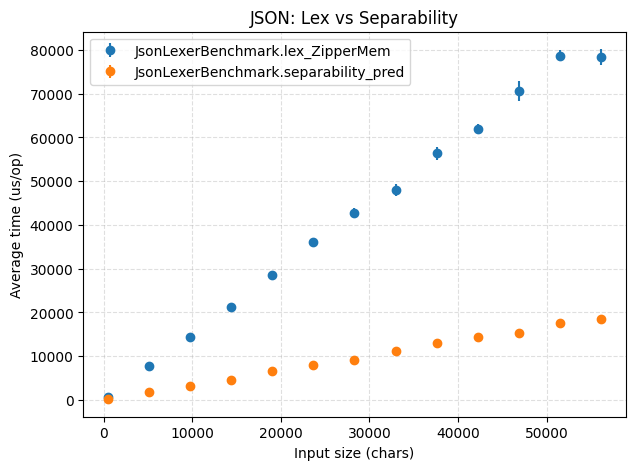

PosixPath('plots/JSON: Lex vs Separability.eps')

In [22]:
bench1 = "JsonLexerBenchmark.lex_ZipperMem"
bench2 = "JsonLexerBenchmark.separability_pred"
d1 = (bench1, data[bench1])
d2 = (bench2, data[bench2])
plot2(d1, d2, title="JSON: Lex vs Separability", output_folder="plots", fmt="eps")